In [175]:
import numpy as np
from matplotlib import pyplot as plt, rcParams
import torch
import torch.optim as optim
import torch.nn as nn
from matplotlib.colors import LogNorm

from jupyterthemes import jtplot
plt.style.use('dark_background')
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
np.random.seed(42)
rcParams['axes.facecolor'] = 'k'
rcParams["figure.facecolor"] = '#212121'
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.serif"] = "Bitstream Vera Serif"
rcParams["font.family"] = "serif"
rcParams["text.usetex"] = False


# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

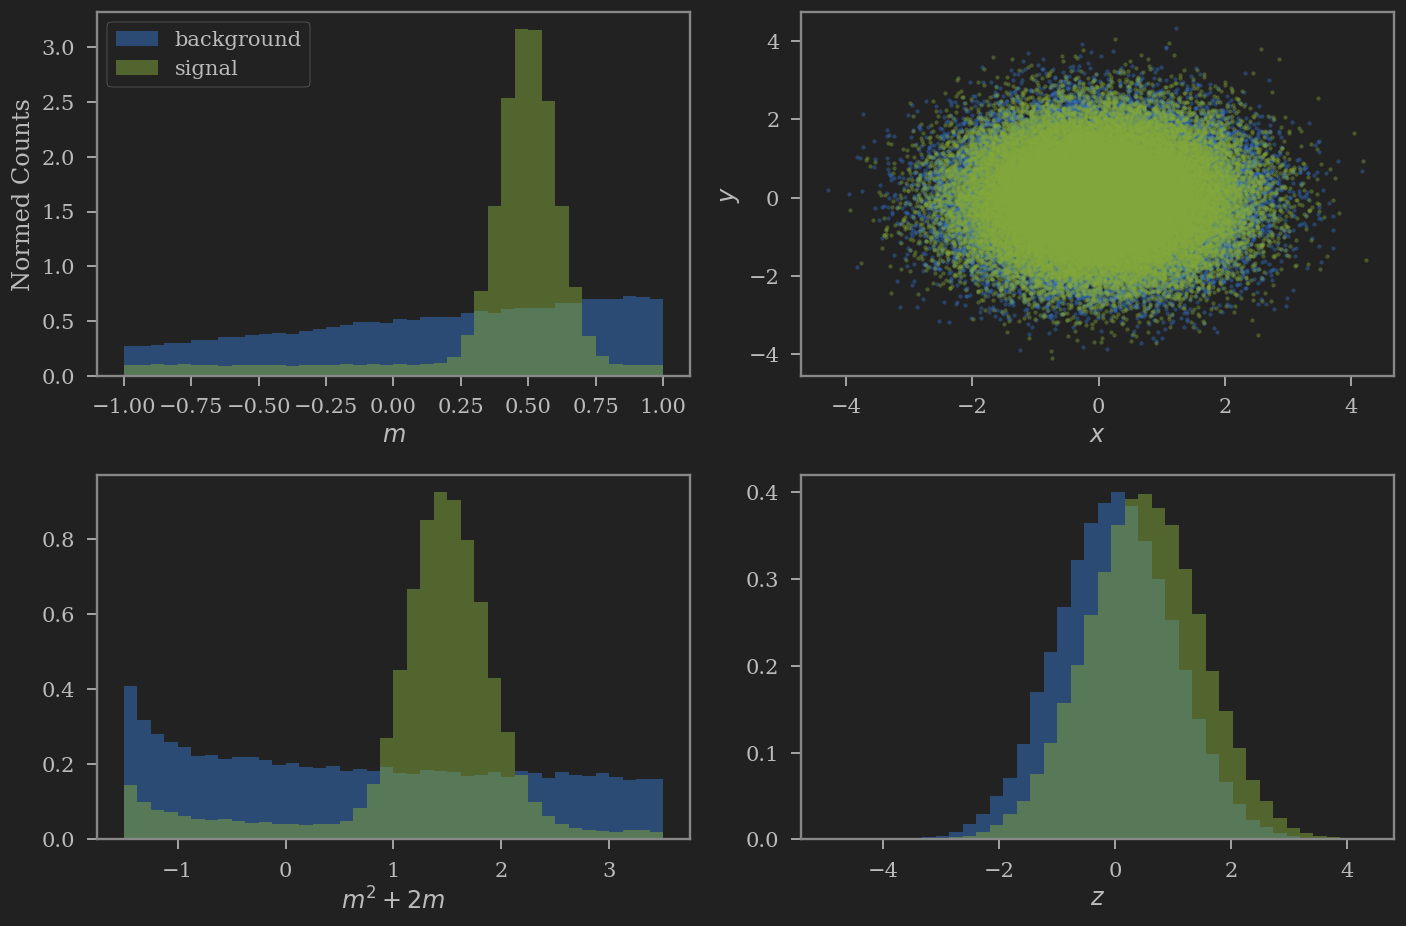

In [266]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,50000)
u_ = np.random.uniform(0,1,50000)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T


z_b = np.random.normal(0,1,n_b)
z_s = np.random.normal(0.5,1,n_s)
z_t = np.random.normal(0,1,n_b)

fig ,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(12,8),dpi=120)

_,bins,_ = ax1.hist(m_b,bins=40,density=True,alpha=0.5, label='background')
ax1.hist(m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax1.legend()
ax1.set_xlabel(r"$m$")
ax1.set_ylabel("Normed Counts")

ax2.scatter(x_b,y_b,s=5,alpha=0.4)
ax2.scatter(x_s,y_s,s=5,alpha=0.4)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")

_,bins,_ = ax3.hist(m_b**2+2.5*m_b,bins=40,density=True,alpha=0.5, label='background')
ax3.hist(m_s**2+2.5*m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax3.set_xlabel(r"$m^2 + 2m$")

_,bins,_ = ax4.hist(z_b,bins=40,density=True,alpha=0.5, label='background')
ax4.hist(z_s,bins=bins,density=True,alpha=0.5,label='signal')
ax4.set_xlabel(r"$z$")

#ax2.set_title("Data")
fig.tight_layout()
plt.savefig("./plots/Data.pdf")
plt.show()

In [234]:
x = np.concatenate([np.stack([m_s,m_s**2+2*m_s,x_s,y_s,z_s],axis=1),
                   np.stack([m_b,m_b**2+2*m_b,x_b,y_b,z_b],axis=1)])
    
#x = np.concatenate([m_s,m_b])
y = np.concatenate([np.ones(m_s.size),np.zeros(m_b.size)])

x_test = np.stack([m_t,m_t**2+2*m_t,x_t,y_t,z_t],axis=1) #,x_test,y_test
y_test = np.ones(n_b)
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]

# Torch Tensors
x_train_tensor = torch.from_numpy(x_train).float().view(-1,5)
y_train_tensor = torch.from_numpy(y_train).float().view(-1,1)
x_val_tensor = torch.from_numpy(x_val).float().view(-1,5)
y_val_tensor = torch.from_numpy(y_val).float().view(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().view(-1,5)
y_test_tensor = torch.from_numpy(y_test).float().view(-1,1)

In [186]:

# Creating the torch model
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(4,16)
        self.linear2 = nn.Linear(16,32)
        self.out = nn.Linear(32,1)
        # Defaults
        self.n_epochs = 200
        self.optimizer = torch.optim.SGD(self.parameters(),lr=1e-1)
        #self.loss = torch.nn.MSELoss()
        
    def forward(self, x):
        x = nn.functional.relu(self.linear(x))
        x = nn.functional.relu(self.linear2(x))
        x = torch.sigmoid(self.out(x))
        return x
    
    def fit(self,x,y,n_epochs=None,optimizer=None,loss=None,interval=100,val_data=[],metrics=[],delay_loss=False):
        if n_epochs: 
            self.n_epochs = n_epochs
        if optimizer: 
            self.optimizer = optimizer
        if loss:
            self.loss = loss
        for epoch in range(self.n_epochs):
            self.train()
            yhat = self(x)
            if epoch<delay_loss:
                l = torch.nn.MSELoss()(yhat,y)
            else:
                l = self.loss(yhat,y)
            l.backward()    
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            if metrics:
                if type(metrics) == list:
                    metrics[0].calculate(pred=yhat,target=y)
                else:
                    metrics.calculate(pred=yhat,target=y,l=l.item())

        #Validation and Printing
            if val_data:
                if epoch % interval ==0 or epoch == self.n_epochs-1:
                    self.train(False)
                    yhat_val = self(val_data[0])
                    l_val = torch.nn.MSELoss()(yhat_val,val_data[1] )
                    if len(metrics)>1:
                        metrics[1].calculate(pred=yhat_val,target=val_data[1],l=l_val.item())
                    acc = metrics[0].accs[-1]
                    acc_val = metrics[1].accs[-1]
                    print('Epoch:{:04d}/{:04d} || Train: loss:{:.4f}, acc:{:.0f}% || Test: loss: {:.4f}, acc:{:.0f}%'.format(
                    epoch,n_epochs,l.item(), 100.* acc,
                    l_val.item(), 100.* acc_val))
            else:
                if epoch % interval ==0:
                    acc = metrics[0].accs[-1]
                    print('Epoch:{:04d}/{:04d} loss: {:.4f}, accuracy:({:.0f}%)'.format(
                        epoch,n_epochs,l.item(), 100.* acc))
                
    
#define some lists to fill
class Metrics():
    def __init__(self):
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
    def calculate(self,pred,target,l=None,validation=False):
        acc = (pred.round()==target).sum().item()/target.shape[0]
        signal_efficiency = ((pred.round()==target)&(target==1)).sum().item()/(target==1).sum().item()
        background_efficiency = ((pred.round()==target)&(target==0)).sum().item()/(target==0).sum().item()
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)
            

In [182]:
class LegendreLoss():
    def __init__(self,frac=0.9):
        self.frac = frac
        self.mass = np.sort(x_train[:,0])
        self.ordered_mass = np.argsort(x_train[:,0])
        self.dm = torch.from_numpy(self.mass.reshape(-1,100)[:,-1] - self.mass.reshape(-1,100)[:,0]).float().view(-1,1)
        self.m = torch.from_numpy(self.mass.reshape(-1,100).mean(axis=1)).float().view(-1,1)
        self.p0 = 1
        self.p1 = self.m
        self.p2 = (self.m**2-1)/2
        self.scores = 0
        self.legendre = 0
    def __call__(self,pred,target):   
        pred_bins = pred[self.ordered_mass].reshape(-1,100)
        ordered_s = pred_bins.argsort(axis=1)
        self.scores = pred_bins.gather(1,ordered_s) # ordered in mass bins in axis 0 and ordered in score in axis 1
        a0 = 1/2 * (self.scores*self.dm).sum(axis=0)
        a1 = 3/2 * (self.scores*self.p1*self.dm).sum(axis=0)
        #mean = pred[self.ordered].reshape(-1,100).mean(axis=1)
        #a0 = 1/2 * (mean*self.dm).sum()
        #a1 = 3/2 * (mean*self.p1*self.dm).sum()
        #a2 = 5/2 * (mean*self.p2*self.dm).sum()
        self.legendre = a0 + a1*self.p1 #+ a2*self.p2
        legendre_loss = ((self.scores - self.legendre)**2).mean()
        return legendre_loss*self.frac + torch.nn.MSELoss()(pred,target)*(1-self.frac)

    
class JiangLoss():
    def __init__(self,eta=1e-3):
        self.gx = (x_train[:,0]<.75)&(x_train[:,0]>.25)
        self.ytrue = (y_train==1)
        self.Z_g = self.gx.sum()/x_train.size
        self.P_g = (self.ytrue&self.gx).sum()/x_train.size
        self.P_x = (self.ytrue).sum()/x_train.size
        self.cx = (self.gx/self.Z_g -1)
        self.lambda1 = 0
        self.weights = np.ones_like(y_train)
        self.eta = eta #1e-3
        self.scores = torch.from_numpy(np.random.randint(0,2,size=y_train.size))
    def __call__(self,pred,target):
        self.weights = np.array(self.weights.tolist()).flatten()
        self.delta =  (np.array(self.scores.tolist()).flatten()*self.cx).mean()      # +(1-yhat)*0
        self.lambda1 -= self.eta*self.delta
        weights_ = np.exp(self.lambda1*self.cx)
        self.weights[y_train==1] = (weights_/(1+weights_))[y_train==1]
        self.weights[y_train==0] = (1/(1+weights_))[y_train==0]
        self.weights = torch.from_numpy(self.weights).view(-1,1)
        self.scores = pred
        return torch.mean(self.weights*(pred-target)**2)

In [235]:
metrics_train_base = Metrics()
metrics_val_base = Metrics()
model_base = Classifier()
model_base.loss = torch.nn.MSELoss()
model_base.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=2000,
               metrics=[metrics_train_base,metrics_val_base], 
               val_data=[x_val_tensor[:,1:],y_val_tensor])

print(metrics_val_base.accs[-1])
print(metrics_val_base.signalE[-1])
print(metrics_val_base.backgroundE[-1])

Epoch:0000/2000 || Train: loss:0.2518, acc:42% || Test: loss: 0.2515, acc:43%
Epoch:0100/2000 || Train: loss:0.2408, acc:64% || Test: loss: 0.2409, acc:64%
Epoch:0200/2000 || Train: loss:0.2331, acc:65% || Test: loss: 0.2332, acc:65%
Epoch:0300/2000 || Train: loss:0.2264, acc:65% || Test: loss: 0.2267, acc:65%
Epoch:0400/2000 || Train: loss:0.2200, acc:66% || Test: loss: 0.2206, acc:66%
Epoch:0500/2000 || Train: loss:0.2129, acc:68% || Test: loss: 0.2139, acc:67%
Epoch:0600/2000 || Train: loss:0.2048, acc:70% || Test: loss: 0.2062, acc:69%
Epoch:0700/2000 || Train: loss:0.1964, acc:72% || Test: loss: 0.1983, acc:71%
Epoch:0800/2000 || Train: loss:0.1886, acc:74% || Test: loss: 0.1908, acc:73%
Epoch:0900/2000 || Train: loss:0.1821, acc:75% || Test: loss: 0.1846, acc:75%
Epoch:1000/2000 || Train: loss:0.1772, acc:76% || Test: loss: 0.1799, acc:75%
Epoch:1100/2000 || Train: loss:0.1737, acc:77% || Test: loss: 0.1766, acc:76%
Epoch:1200/2000 || Train: loss:0.1713, acc:77% || Test: loss: 0.

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


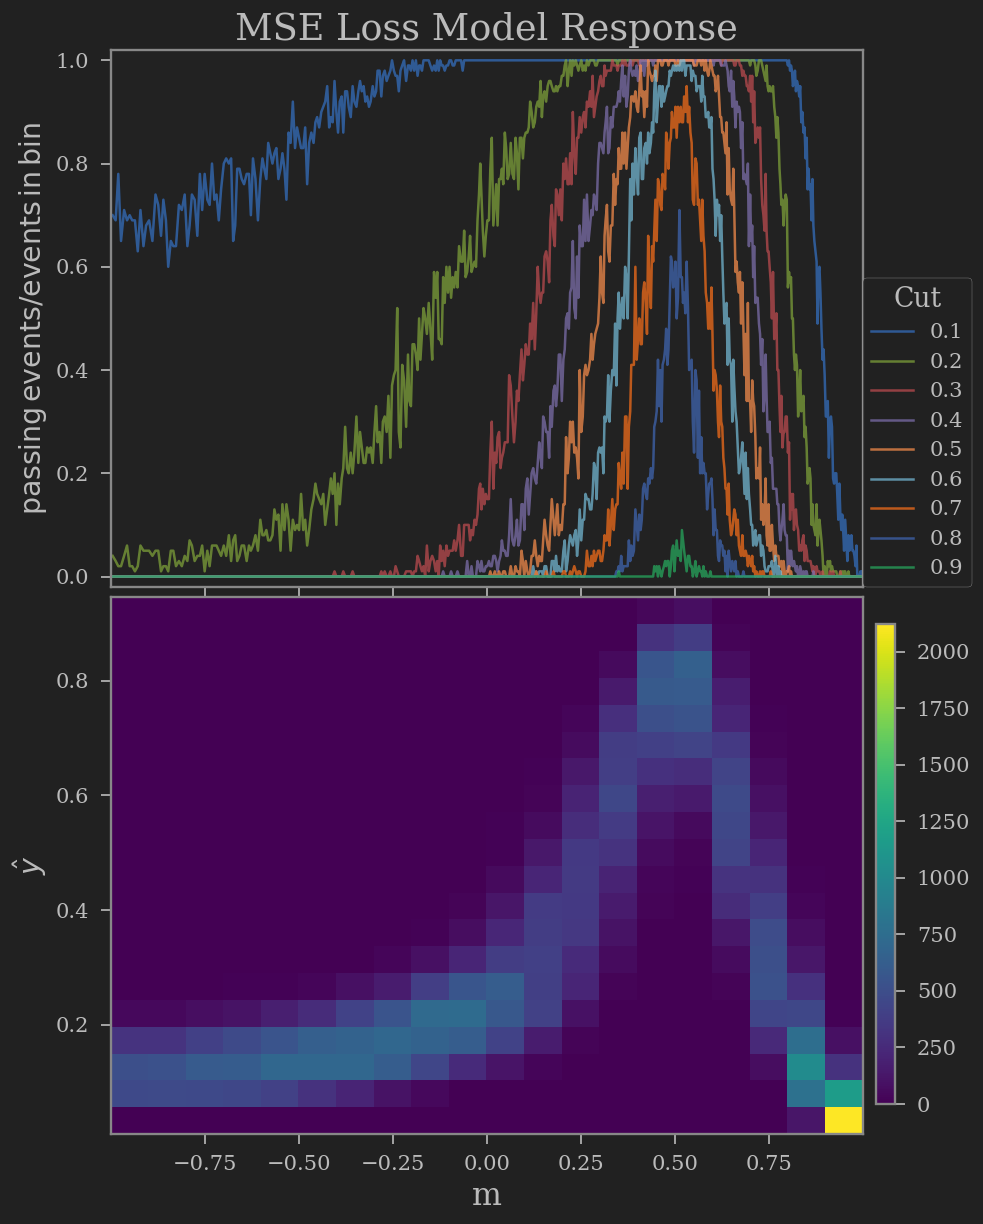

In [276]:
scores = np.array(model_base(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)



fig, [ax1, ax2]  = plt.subplots(2,1,figsize=[8,5*2],dpi=120,sharex=True)
for j,cut in enumerate(np.linspace(0.1,0.9,9)):
    c = f"C{j}" if j!= 6 else f"C11"
    passed = (scores>cut).sum(axis=1)/scores.shape[1]
    ax1.plot(m,passed,label="{:0.1f}".format(cut),alpha=0.7,c=c)

    #plt.plot(m,base[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
ax1.set_ylim([-0.02,1.02])
ax1.set_title("MSE Loss Model Response",fontsize=22)
ax1.legend(loc=(1,0),markerscale=5,title="Cut",ncol=1)

_,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=20, label="all",)#norm=LogNorm())
cbaxes = fig.add_axes([0.9, 0.09, 0.02, 0.4]) 
plt.colorbar(h,ax=ax2,cax = cbaxes)
ax2.set_ylabel(r"$\hat{y}$",fontsize=17)
ax2.set_xlabel("m",fontsize=19)
fig.tight_layout(pad=0)
plt.show()

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


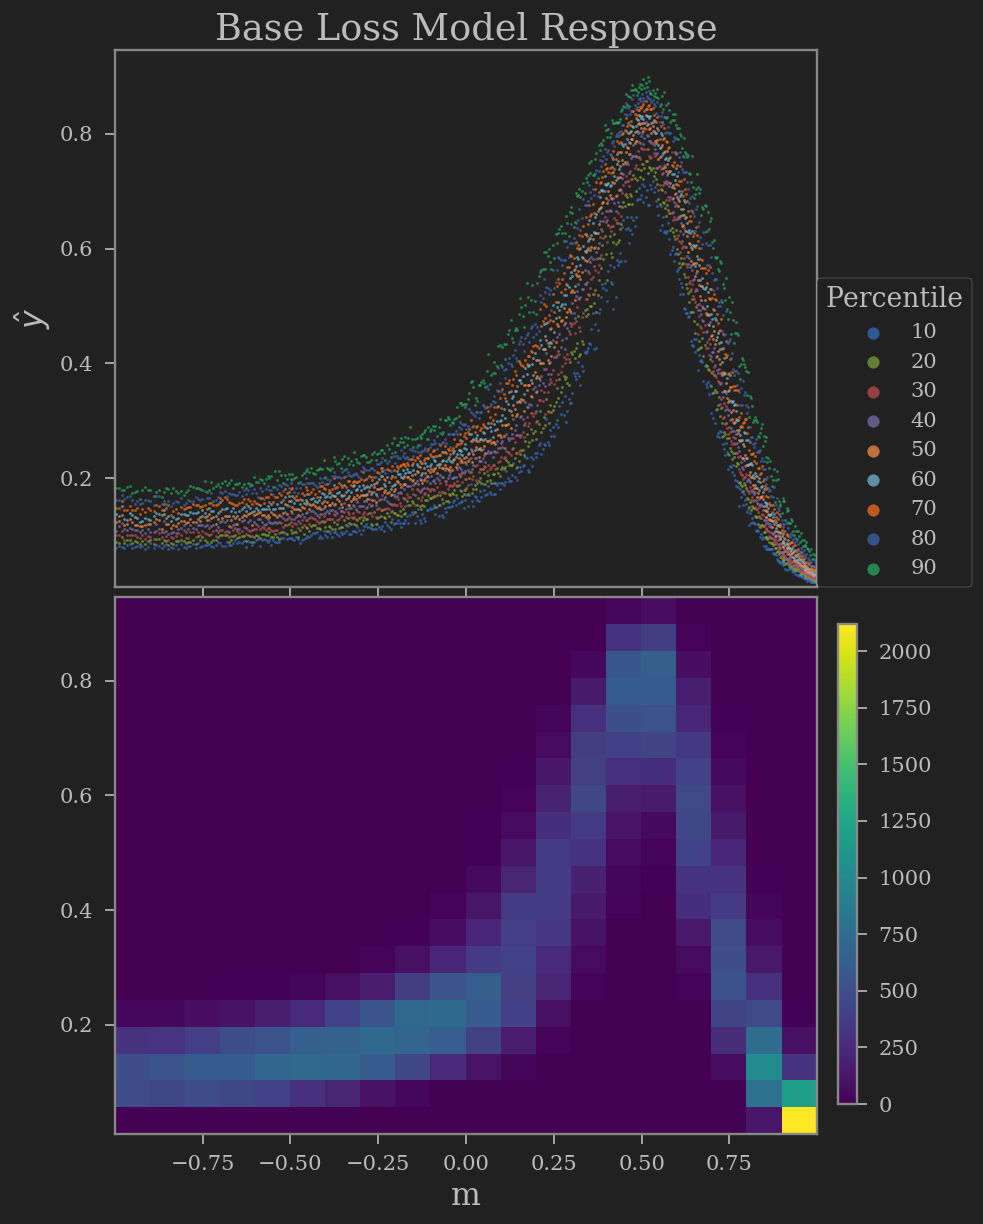

In [275]:
scores = np.array(model_base(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
ordered_score = scores.argsort(axis=1)
scores = scores[np.arange(scores.shape[0])[:, None], ordered_score]


fig, [ax1, ax2]  = plt.subplots(2,1,figsize=[8,5*2],dpi=120,sharex=True,sharey=True)
for j,i in enumerate(range(10,scores.shape[1],10)):
    c = f"C{j}" if j!= 6 else f"C11"
    ax1.scatter(m,scores[:,i],label=f"{int(i*100/scores.shape[1])}",alpha=0.7,s=2,c=c)

    #plt.plot(m,base[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
ax1.set_ylabel(r"$\hat{y}$",fontsize=19)
ax1.set_title("Base Loss Model Response",fontsize=22)
ax1.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=1)

_,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=20, label="all",)#norm=LogNorm())
cbaxes = fig.add_axes([0.86, 0.09, 0.02, 0.4]) 
plt.colorbar(h,ax=ax2,cax = cbaxes)
ax2.set_xlabel("m",fontsize=19)
#plt.ylim([0,0.7])
fig.tight_layout(pad=0)
plt.show()

0.0
Epoch:0000/2000 || Train: loss:0.2591, acc:50% || Test: loss: 0.2579, acc:50%
Epoch:0100/2000 || Train: loss:0.2391, acc:66% || Test: loss: 0.2392, acc:65%
Epoch:0200/2000 || Train: loss:0.2295, acc:66% || Test: loss: 0.2300, acc:66%
Epoch:0300/2000 || Train: loss:0.2219, acc:66% || Test: loss: 0.2227, acc:66%
Epoch:0400/2000 || Train: loss:0.2156, acc:67% || Test: loss: 0.2167, acc:67%
Epoch:0500/2000 || Train: loss:0.2088, acc:68% || Test: loss: 0.2102, acc:68%
Epoch:0600/2000 || Train: loss:0.2014, acc:70% || Test: loss: 0.2032, acc:70%
Epoch:0700/2000 || Train: loss:0.1939, acc:72% || Test: loss: 0.1962, acc:72%
Epoch:0800/2000 || Train: loss:0.1868, acc:74% || Test: loss: 0.1894, acc:74%
Epoch:0900/2000 || Train: loss:0.1807, acc:76% || Test: loss: 0.1835, acc:75%
Epoch:1000/2000 || Train: loss:0.1759, acc:76% || Test: loss: 0.1788, acc:76%
Epoch:1100/2000 || Train: loss:0.1723, acc:77% || Test: loss: 0.1753, acc:76%
Epoch:1200/2000 || Train: loss:0.1698, acc:77% || Test: loss

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


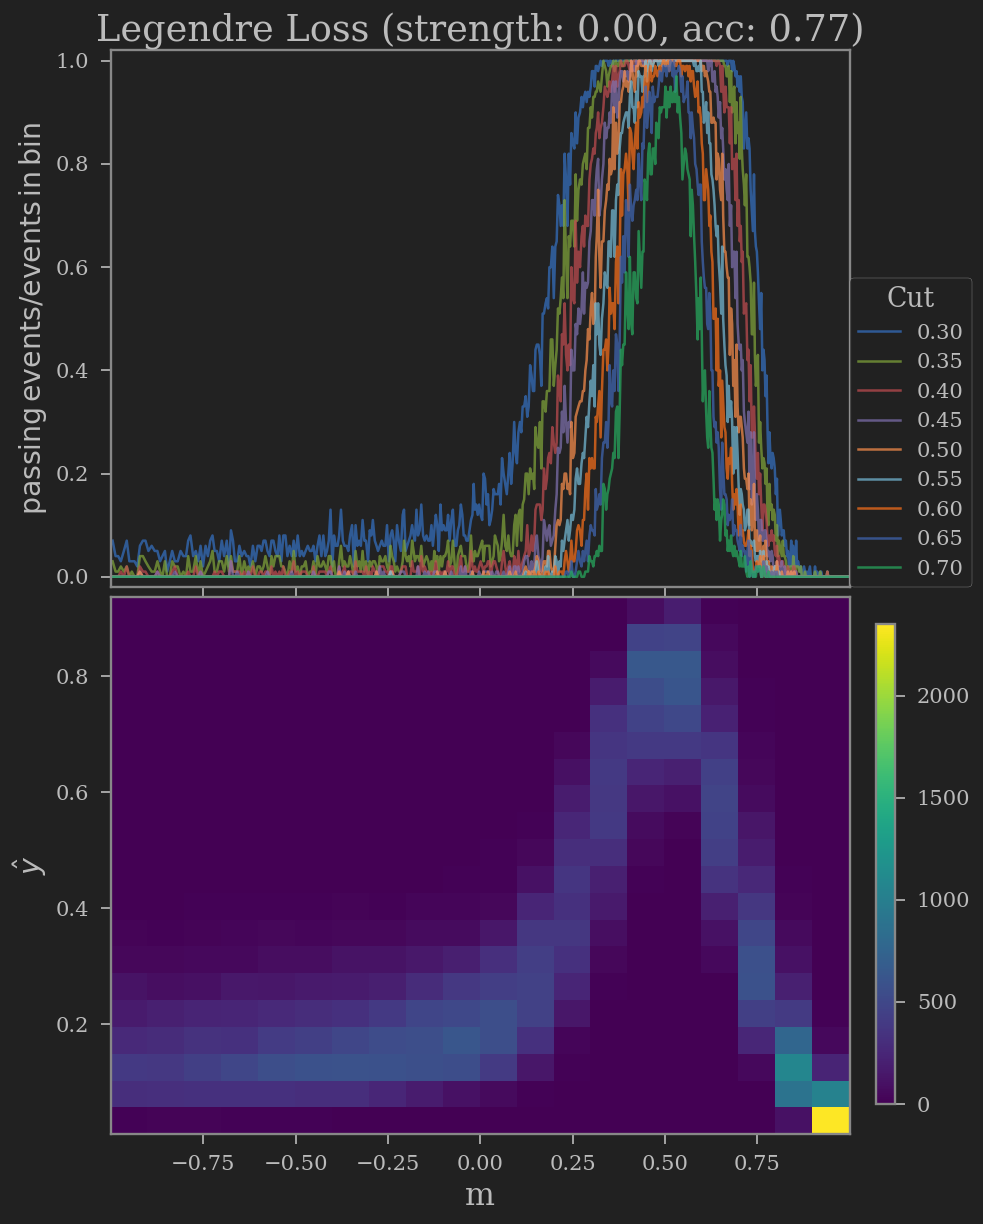

0.1
Epoch:0000/2000 || Train: loss:0.2259, acc:50% || Test: loss: 0.2507, acc:50%
Epoch:0100/2000 || Train: loss:0.2158, acc:66% || Test: loss: 0.2397, acc:66%
Epoch:0200/2000 || Train: loss:0.2068, acc:67% || Test: loss: 0.2299, acc:66%
Epoch:0300/2000 || Train: loss:0.1985, acc:67% || Test: loss: 0.2209, acc:67%
Epoch:0400/2000 || Train: loss:0.1925, acc:68% || Test: loss: 0.2146, acc:67%
Epoch:0500/2000 || Train: loss:0.1880, acc:69% || Test: loss: 0.2097, acc:68%
Epoch:0600/2000 || Train: loss:0.1840, acc:70% || Test: loss: 0.2053, acc:69%
Epoch:0700/2000 || Train: loss:0.1801, acc:71% || Test: loss: 0.2010, acc:70%
Epoch:0800/2000 || Train: loss:0.1764, acc:72% || Test: loss: 0.1967, acc:72%
Epoch:0900/2000 || Train: loss:0.1729, acc:73% || Test: loss: 0.1926, acc:73%
Epoch:1000/2000 || Train: loss:0.1697, acc:75% || Test: loss: 0.1888, acc:74%
Epoch:1100/2000 || Train: loss:0.1670, acc:75% || Test: loss: 0.1853, acc:75%
Epoch:1200/2000 || Train: loss:0.1647, acc:76% || Test: loss

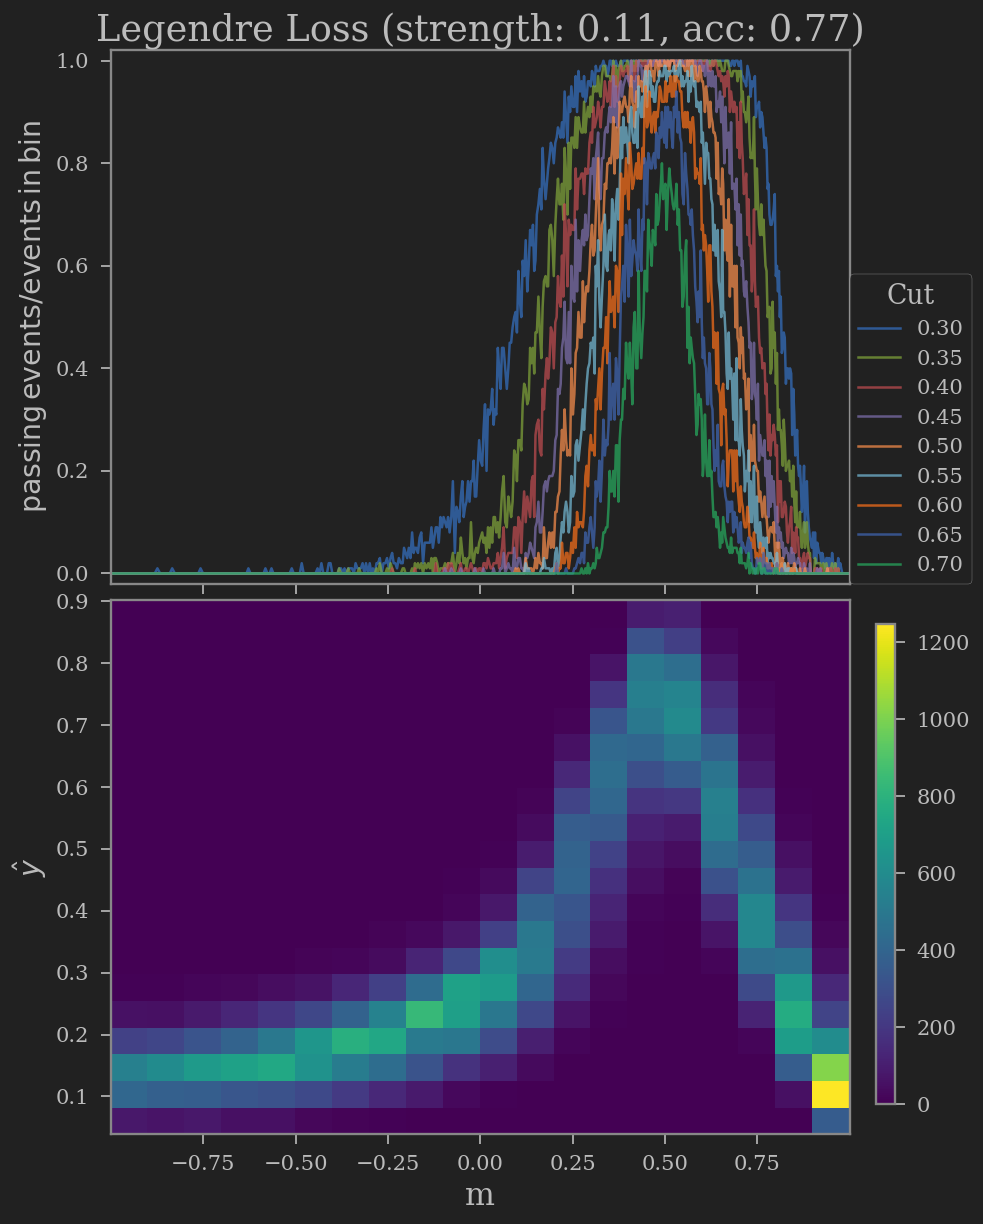

0.2
Epoch:0000/2000 || Train: loss:0.2015, acc:50% || Test: loss: 0.2516, acc:50%
Epoch:0100/2000 || Train: loss:0.1948, acc:68% || Test: loss: 0.2435, acc:67%
Epoch:0200/2000 || Train: loss:0.1874, acc:69% || Test: loss: 0.2345, acc:68%
Epoch:0300/2000 || Train: loss:0.1786, acc:68% || Test: loss: 0.2237, acc:68%
Epoch:0400/2000 || Train: loss:0.1720, acc:68% || Test: loss: 0.2154, acc:68%
Epoch:0500/2000 || Train: loss:0.1680, acc:69% || Test: loss: 0.2104, acc:68%
Epoch:0600/2000 || Train: loss:0.1652, acc:70% || Test: loss: 0.2066, acc:69%
Epoch:0700/2000 || Train: loss:0.1627, acc:71% || Test: loss: 0.2033, acc:70%
Epoch:0800/2000 || Train: loss:0.1605, acc:72% || Test: loss: 0.2001, acc:71%
Epoch:0900/2000 || Train: loss:0.1585, acc:72% || Test: loss: 0.1972, acc:72%
Epoch:1000/2000 || Train: loss:0.1567, acc:73% || Test: loss: 0.1945, acc:73%
Epoch:1100/2000 || Train: loss:0.1552, acc:74% || Test: loss: 0.1921, acc:73%
Epoch:1200/2000 || Train: loss:0.1539, acc:74% || Test: loss

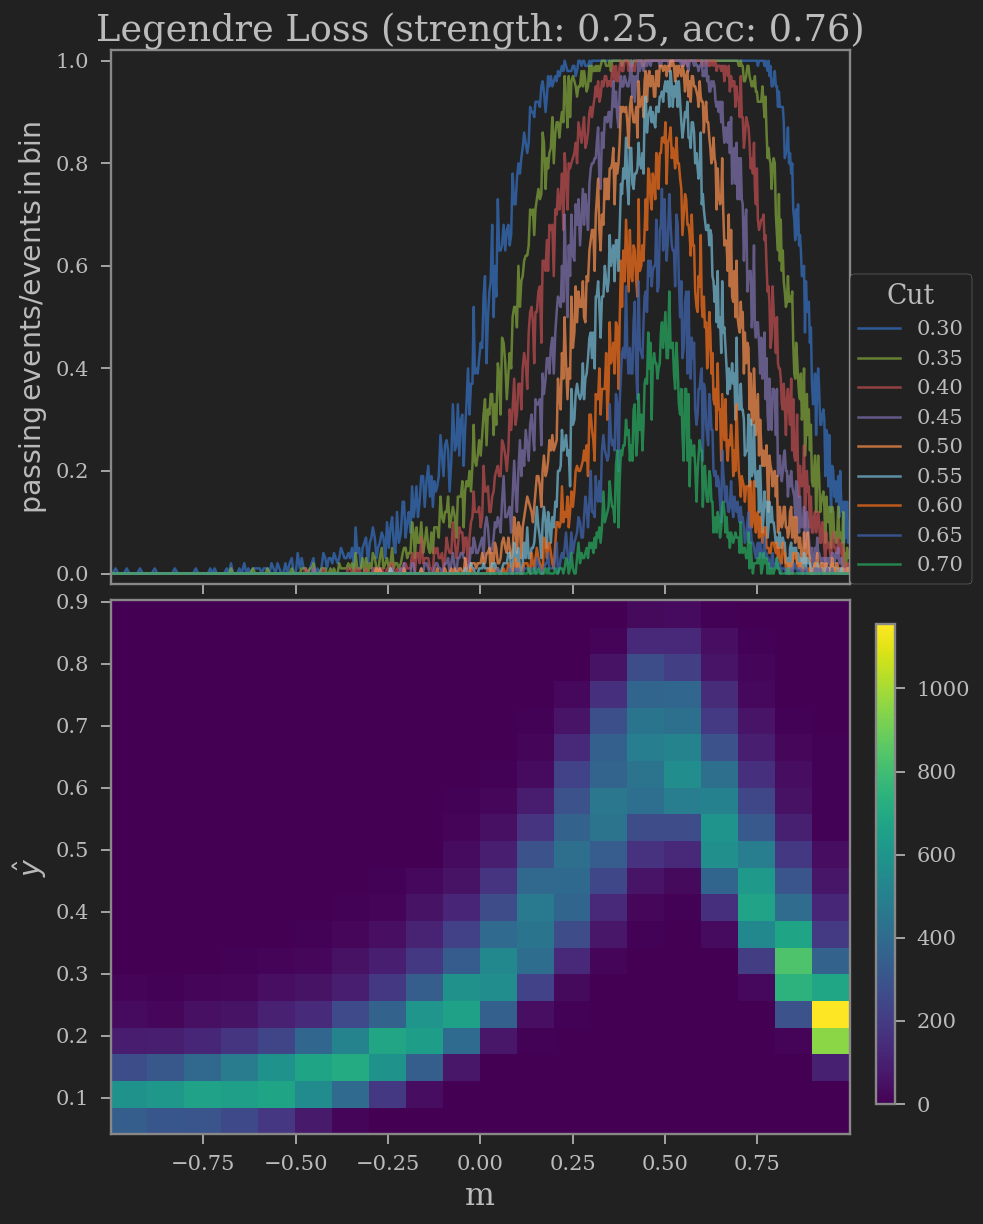

0.30000000000000004
Epoch:0000/2000 || Train: loss:0.1759, acc:50% || Test: loss: 0.2512, acc:50%
Epoch:0100/2000 || Train: loss:0.1667, acc:64% || Test: loss: 0.2380, acc:64%
Epoch:0200/2000 || Train: loss:0.1611, acc:64% || Test: loss: 0.2298, acc:64%
Epoch:0300/2000 || Train: loss:0.1566, acc:65% || Test: loss: 0.2233, acc:64%
Epoch:0400/2000 || Train: loss:0.1532, acc:66% || Test: loss: 0.2183, acc:66%
Epoch:0500/2000 || Train: loss:0.1505, acc:66% || Test: loss: 0.2143, acc:66%
Epoch:0600/2000 || Train: loss:0.1483, acc:67% || Test: loss: 0.2110, acc:67%
Epoch:0700/2000 || Train: loss:0.1464, acc:68% || Test: loss: 0.2082, acc:68%
Epoch:0800/2000 || Train: loss:0.1449, acc:69% || Test: loss: 0.2057, acc:69%
Epoch:0900/2000 || Train: loss:0.1435, acc:70% || Test: loss: 0.2035, acc:70%
Epoch:1000/2000 || Train: loss:0.1423, acc:71% || Test: loss: 0.2013, acc:71%
Epoch:1100/2000 || Train: loss:0.1411, acc:72% || Test: loss: 0.1992, acc:71%
Epoch:1200/2000 || Train: loss:0.1401, acc:7

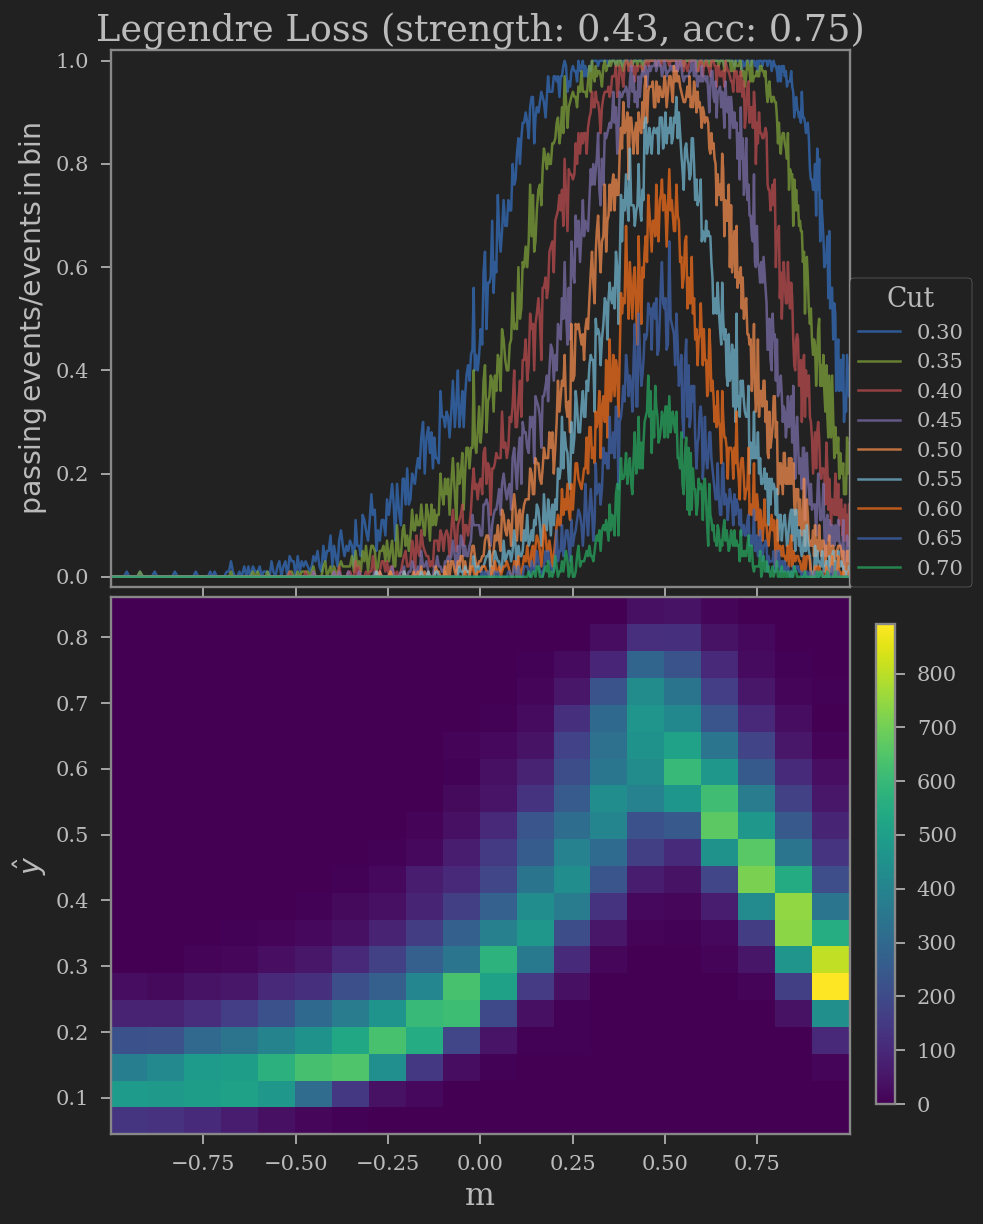

0.4
Epoch:0000/2000 || Train: loss:0.1518, acc:44% || Test: loss: 0.2529, acc:44%
Epoch:0100/2000 || Train: loss:0.1467, acc:64% || Test: loss: 0.2445, acc:64%
Epoch:0200/2000 || Train: loss:0.1422, acc:65% || Test: loss: 0.2371, acc:65%
Epoch:0300/2000 || Train: loss:0.1379, acc:66% || Test: loss: 0.2299, acc:65%
Epoch:0400/2000 || Train: loss:0.1343, acc:66% || Test: loss: 0.2238, acc:66%
Epoch:0500/2000 || Train: loss:0.1317, acc:66% || Test: loss: 0.2192, acc:66%
Epoch:0600/2000 || Train: loss:0.1298, acc:67% || Test: loss: 0.2159, acc:67%
Epoch:0700/2000 || Train: loss:0.1283, acc:68% || Test: loss: 0.2131, acc:67%
Epoch:0800/2000 || Train: loss:0.1271, acc:68% || Test: loss: 0.2107, acc:68%
Epoch:0900/2000 || Train: loss:0.1260, acc:69% || Test: loss: 0.2084, acc:68%
Epoch:1000/2000 || Train: loss:0.1251, acc:70% || Test: loss: 0.2064, acc:69%
Epoch:1100/2000 || Train: loss:0.1242, acc:70% || Test: loss: 0.2044, acc:70%
Epoch:1200/2000 || Train: loss:0.1235, acc:71% || Test: loss

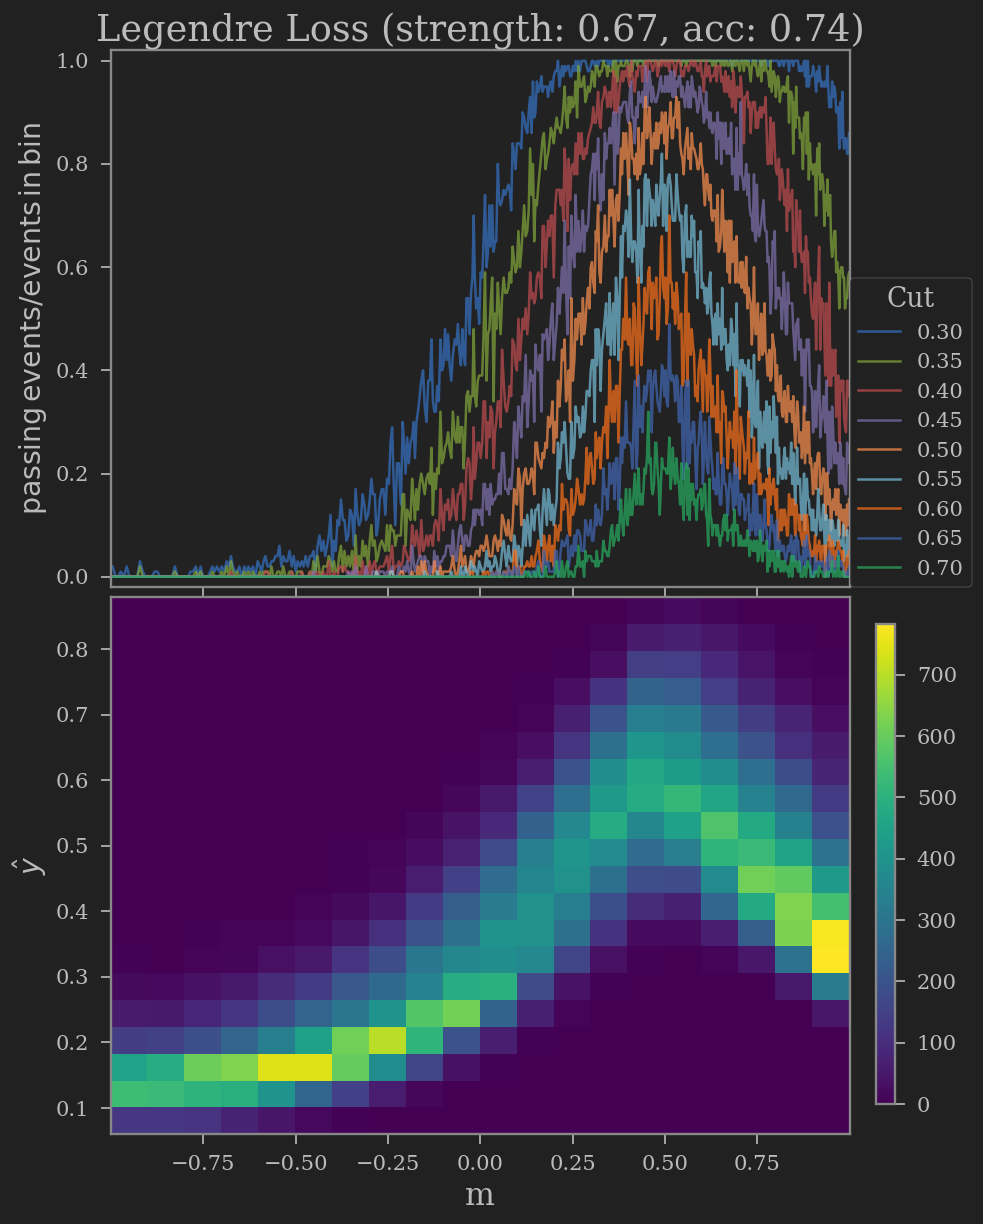

0.5
Epoch:0000/2000 || Train: loss:0.1235, acc:59% || Test: loss: 0.2470, acc:59%
Epoch:0100/2000 || Train: loss:0.1211, acc:65% || Test: loss: 0.2423, acc:64%
Epoch:0200/2000 || Train: loss:0.1184, acc:65% || Test: loss: 0.2369, acc:65%
Epoch:0300/2000 || Train: loss:0.1154, acc:66% || Test: loss: 0.2309, acc:65%
Epoch:0400/2000 || Train: loss:0.1126, acc:66% || Test: loss: 0.2253, acc:65%
Epoch:0500/2000 || Train: loss:0.1105, acc:66% || Test: loss: 0.2208, acc:66%
Epoch:0600/2000 || Train: loss:0.1091, acc:66% || Test: loss: 0.2176, acc:66%
Epoch:0700/2000 || Train: loss:0.1082, acc:66% || Test: loss: 0.2153, acc:66%
Epoch:0800/2000 || Train: loss:0.1075, acc:66% || Test: loss: 0.2136, acc:66%
Epoch:0900/2000 || Train: loss:0.1069, acc:66% || Test: loss: 0.2121, acc:66%
Epoch:1000/2000 || Train: loss:0.1065, acc:67% || Test: loss: 0.2107, acc:66%
Epoch:1100/2000 || Train: loss:0.1060, acc:67% || Test: loss: 0.2094, acc:66%
Epoch:1200/2000 || Train: loss:0.1056, acc:68% || Test: loss

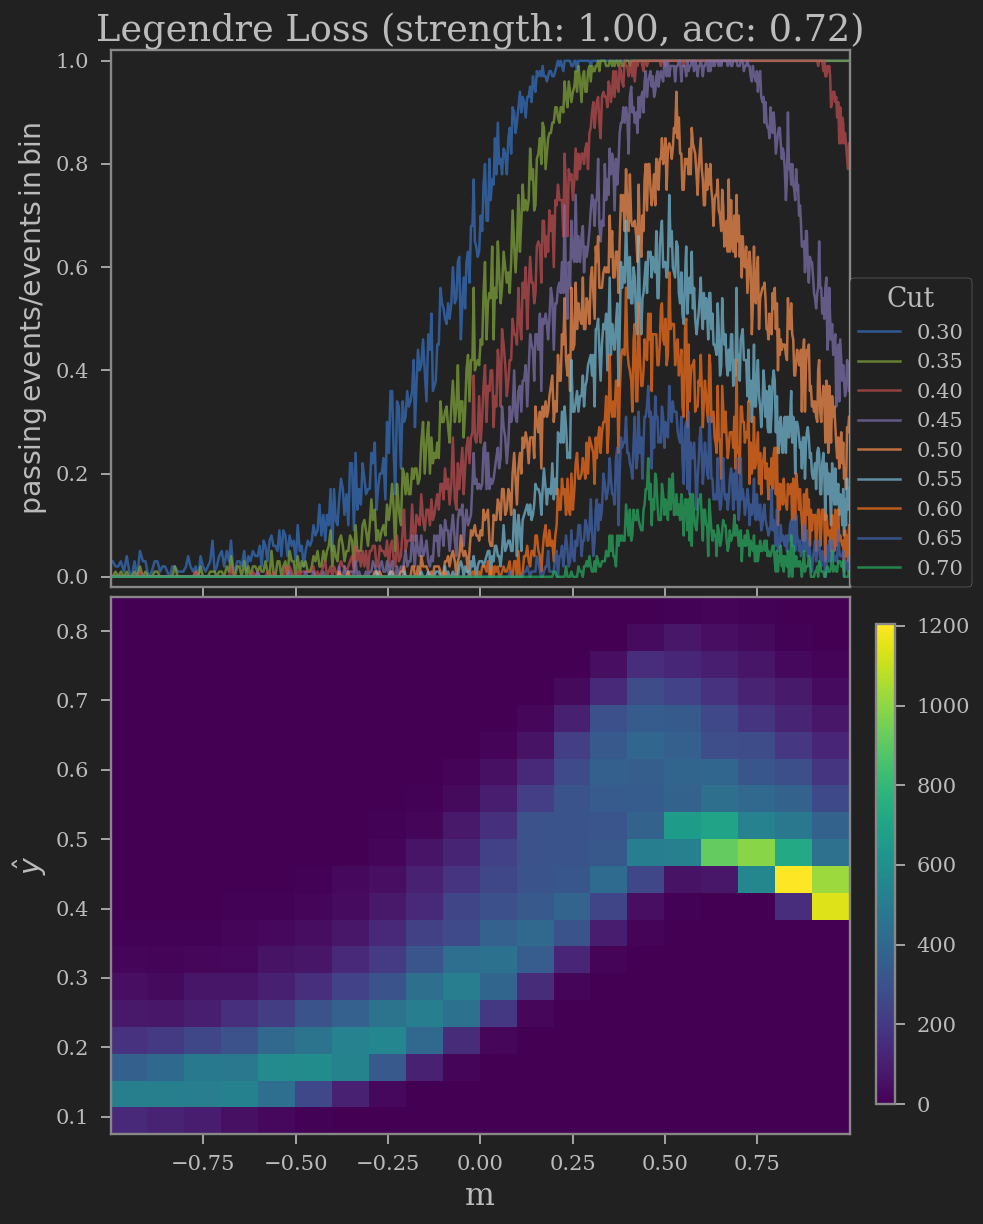

0.6000000000000001
Epoch:0000/2000 || Train: loss:0.1007, acc:46% || Test: loss: 0.2513, acc:46%
Epoch:0100/2000 || Train: loss:0.0974, acc:56% || Test: loss: 0.2434, acc:56%
Epoch:0200/2000 || Train: loss:0.0961, acc:60% || Test: loss: 0.2399, acc:60%
Epoch:0300/2000 || Train: loss:0.0949, acc:62% || Test: loss: 0.2370, acc:62%
Epoch:0400/2000 || Train: loss:0.0939, acc:63% || Test: loss: 0.2343, acc:63%
Epoch:0500/2000 || Train: loss:0.0930, acc:64% || Test: loss: 0.2318, acc:64%
Epoch:0600/2000 || Train: loss:0.0921, acc:65% || Test: loss: 0.2296, acc:64%
Epoch:0700/2000 || Train: loss:0.0913, acc:65% || Test: loss: 0.2274, acc:65%
Epoch:0800/2000 || Train: loss:0.0905, acc:65% || Test: loss: 0.2252, acc:65%
Epoch:0900/2000 || Train: loss:0.0897, acc:66% || Test: loss: 0.2231, acc:66%
Epoch:1000/2000 || Train: loss:0.0890, acc:66% || Test: loss: 0.2210, acc:66%
Epoch:1100/2000 || Train: loss:0.0884, acc:67% || Test: loss: 0.2190, acc:66%
Epoch:1200/2000 || Train: loss:0.0878, acc:67

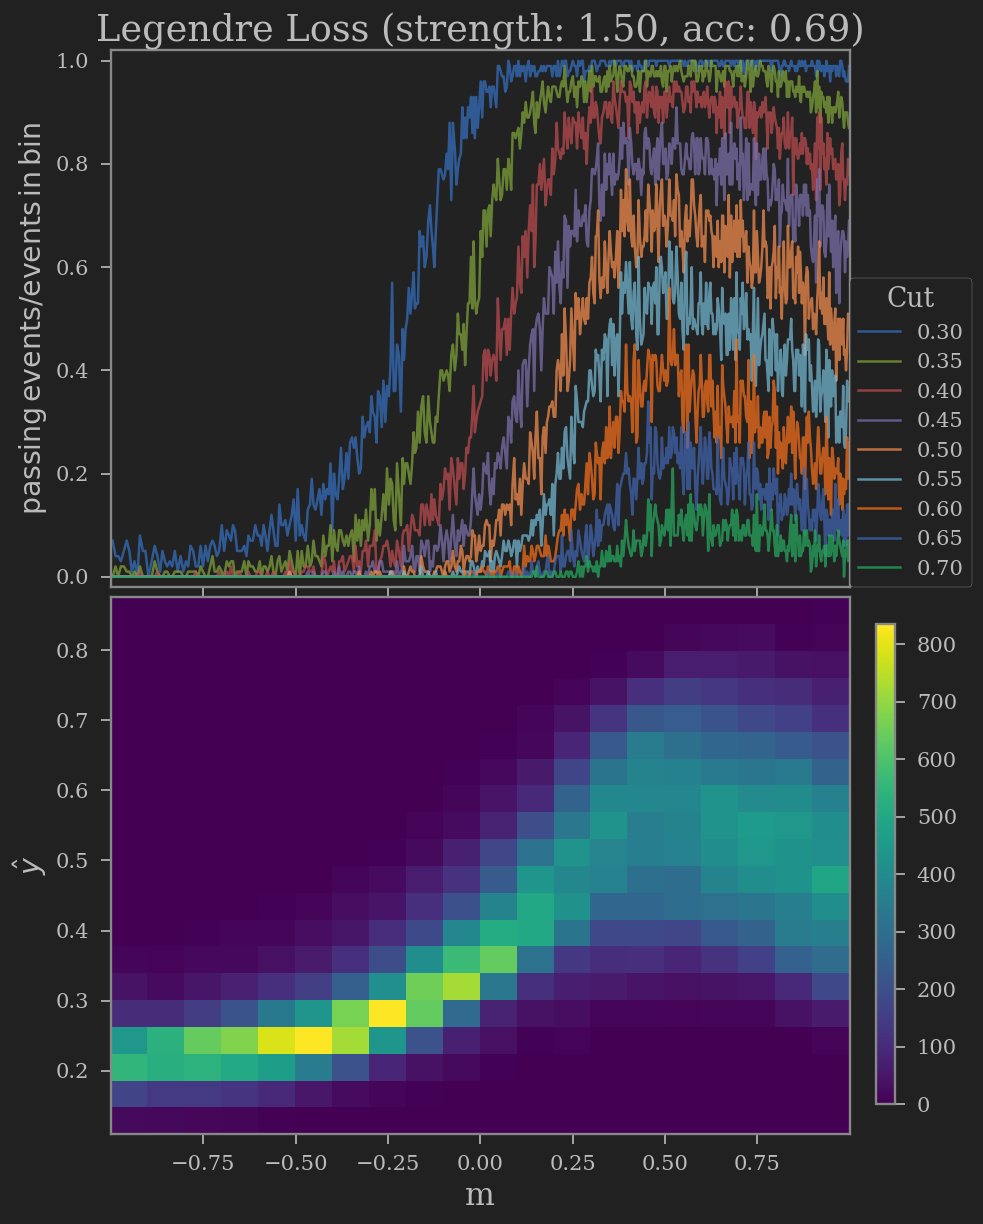

0.7000000000000001
Epoch:0000/2000 || Train: loss:0.0765, acc:50% || Test: loss: 0.2546, acc:50%
Epoch:0100/2000 || Train: loss:0.0748, acc:50% || Test: loss: 0.2490, acc:50%
Epoch:0200/2000 || Train: loss:0.0736, acc:50% || Test: loss: 0.2452, acc:50%
Epoch:0300/2000 || Train: loss:0.0726, acc:59% || Test: loss: 0.2418, acc:60%
Epoch:0400/2000 || Train: loss:0.0716, acc:62% || Test: loss: 0.2384, acc:62%
Epoch:0500/2000 || Train: loss:0.0706, acc:63% || Test: loss: 0.2350, acc:63%
Epoch:0600/2000 || Train: loss:0.0696, acc:64% || Test: loss: 0.2315, acc:64%
Epoch:0700/2000 || Train: loss:0.0687, acc:65% || Test: loss: 0.2282, acc:64%
Epoch:0800/2000 || Train: loss:0.0679, acc:65% || Test: loss: 0.2253, acc:65%
Epoch:0900/2000 || Train: loss:0.0672, acc:66% || Test: loss: 0.2226, acc:65%
Epoch:1000/2000 || Train: loss:0.0667, acc:66% || Test: loss: 0.2204, acc:66%
Epoch:1100/2000 || Train: loss:0.0663, acc:67% || Test: loss: 0.2185, acc:66%
Epoch:1200/2000 || Train: loss:0.0660, acc:67

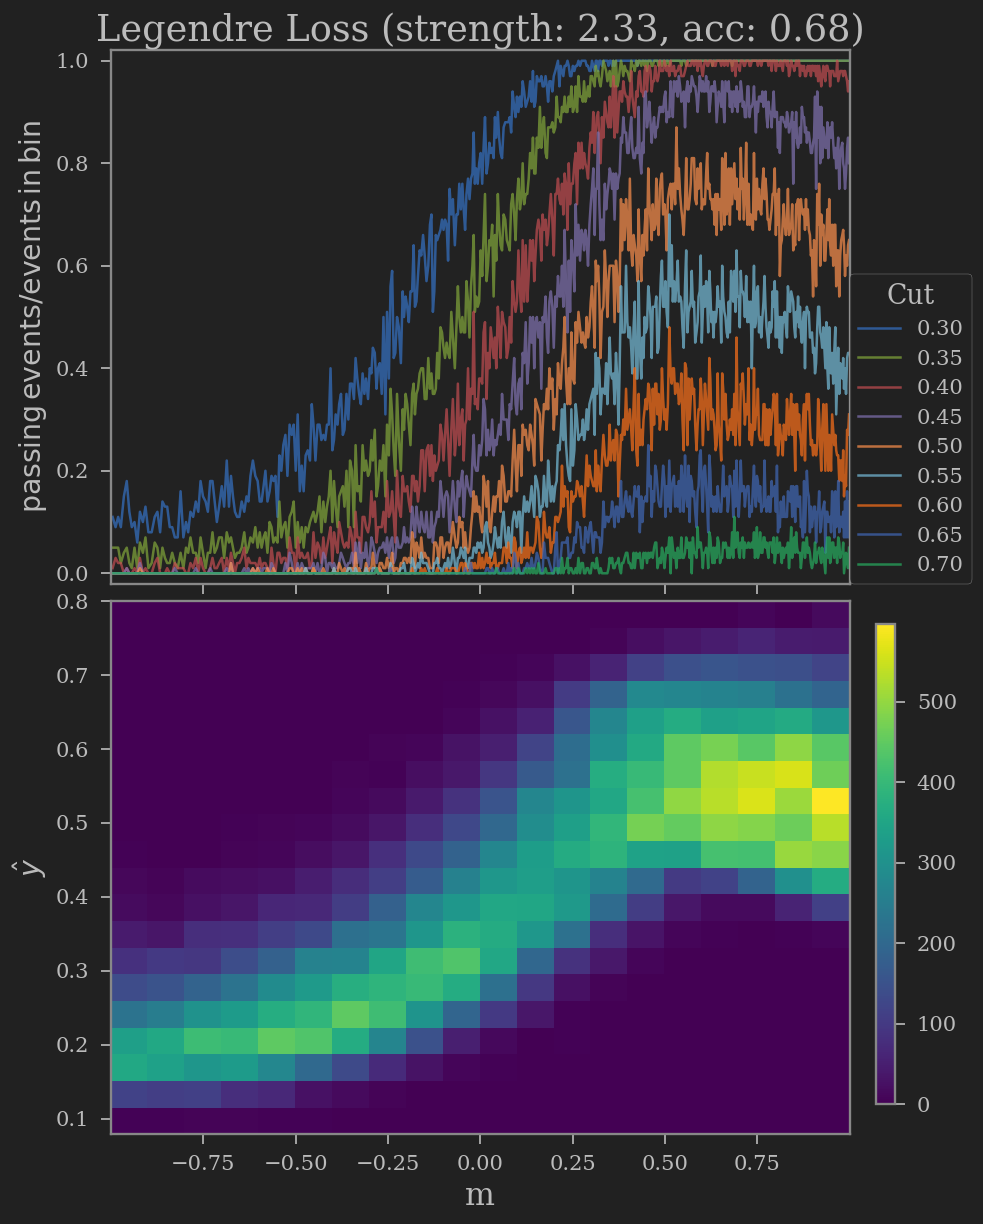

0.8
Epoch:0000/2000 || Train: loss:0.0505, acc:50% || Test: loss: 0.2525, acc:50%
Epoch:0100/2000 || Train: loss:0.0496, acc:48% || Test: loss: 0.2478, acc:48%
Epoch:0200/2000 || Train: loss:0.0490, acc:50% || Test: loss: 0.2449, acc:50%
Epoch:0300/2000 || Train: loss:0.0485, acc:65% || Test: loss: 0.2424, acc:65%
Epoch:0400/2000 || Train: loss:0.0480, acc:66% || Test: loss: 0.2401, acc:66%
Epoch:0500/2000 || Train: loss:0.0476, acc:66% || Test: loss: 0.2378, acc:66%
Epoch:0600/2000 || Train: loss:0.0472, acc:66% || Test: loss: 0.2355, acc:66%
Epoch:0700/2000 || Train: loss:0.0468, acc:66% || Test: loss: 0.2333, acc:66%
Epoch:0800/2000 || Train: loss:0.0464, acc:66% || Test: loss: 0.2311, acc:66%
Epoch:0900/2000 || Train: loss:0.0460, acc:66% || Test: loss: 0.2291, acc:66%
Epoch:1000/2000 || Train: loss:0.0457, acc:66% || Test: loss: 0.2273, acc:66%
Epoch:1100/2000 || Train: loss:0.0455, acc:66% || Test: loss: 0.2256, acc:66%
Epoch:1200/2000 || Train: loss:0.0453, acc:66% || Test: loss

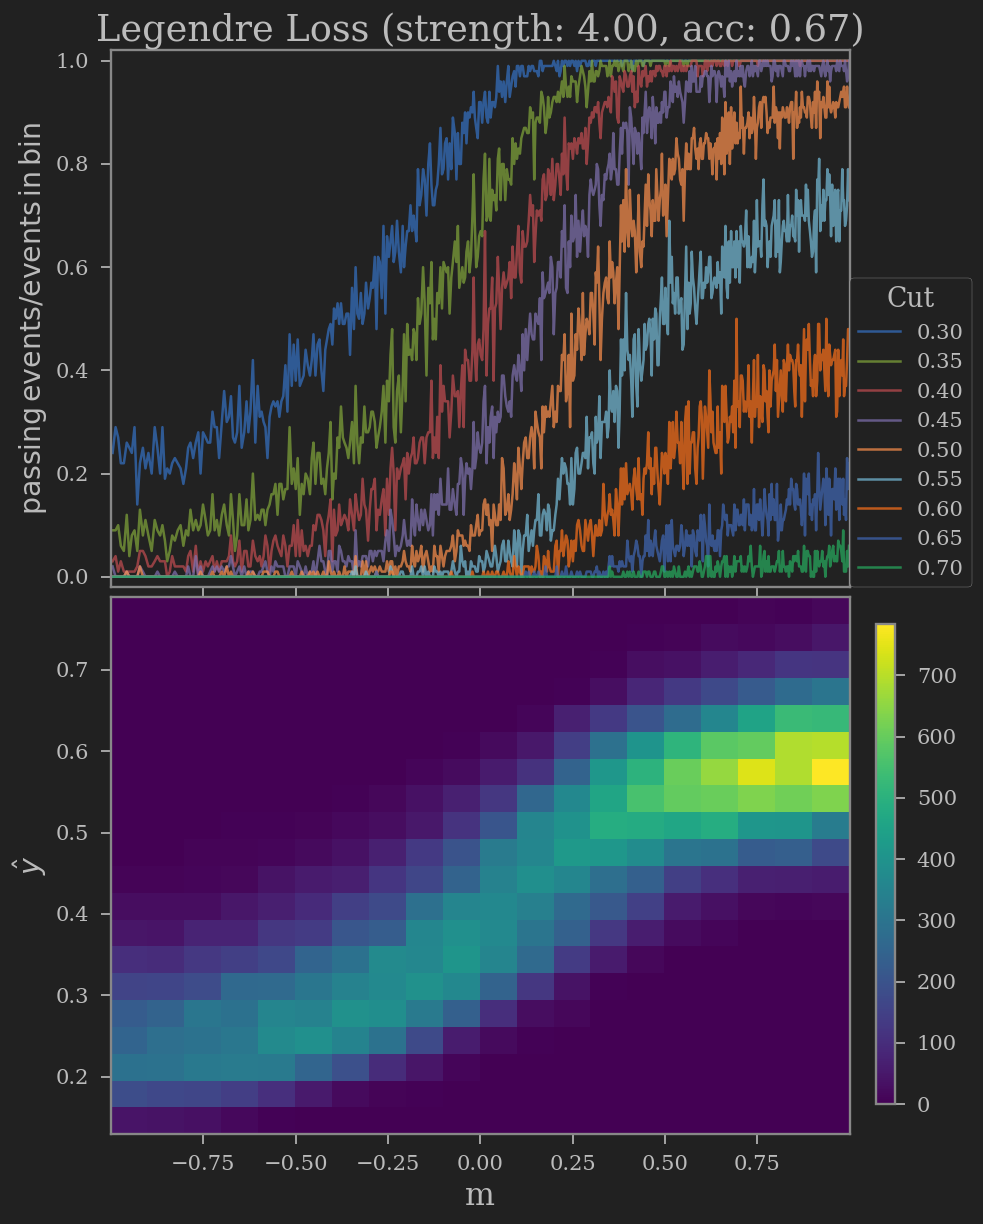

0.9
Epoch:0000/2000 || Train: loss:0.0250, acc:50% || Test: loss: 0.2502, acc:50%
Epoch:0100/2000 || Train: loss:0.0249, acc:51% || Test: loss: 0.2489, acc:51%
Epoch:0200/2000 || Train: loss:0.0248, acc:54% || Test: loss: 0.2479, acc:54%
Epoch:0300/2000 || Train: loss:0.0247, acc:57% || Test: loss: 0.2470, acc:57%
Epoch:0400/2000 || Train: loss:0.0247, acc:60% || Test: loss: 0.2461, acc:60%
Epoch:0500/2000 || Train: loss:0.0246, acc:61% || Test: loss: 0.2454, acc:61%
Epoch:0600/2000 || Train: loss:0.0245, acc:62% || Test: loss: 0.2446, acc:62%
Epoch:0700/2000 || Train: loss:0.0244, acc:62% || Test: loss: 0.2439, acc:62%
Epoch:0800/2000 || Train: loss:0.0244, acc:63% || Test: loss: 0.2431, acc:62%
Epoch:0900/2000 || Train: loss:0.0243, acc:63% || Test: loss: 0.2424, acc:62%
Epoch:1000/2000 || Train: loss:0.0243, acc:63% || Test: loss: 0.2417, acc:63%
Epoch:1100/2000 || Train: loss:0.0242, acc:63% || Test: loss: 0.2410, acc:63%
Epoch:1200/2000 || Train: loss:0.0241, acc:63% || Test: loss

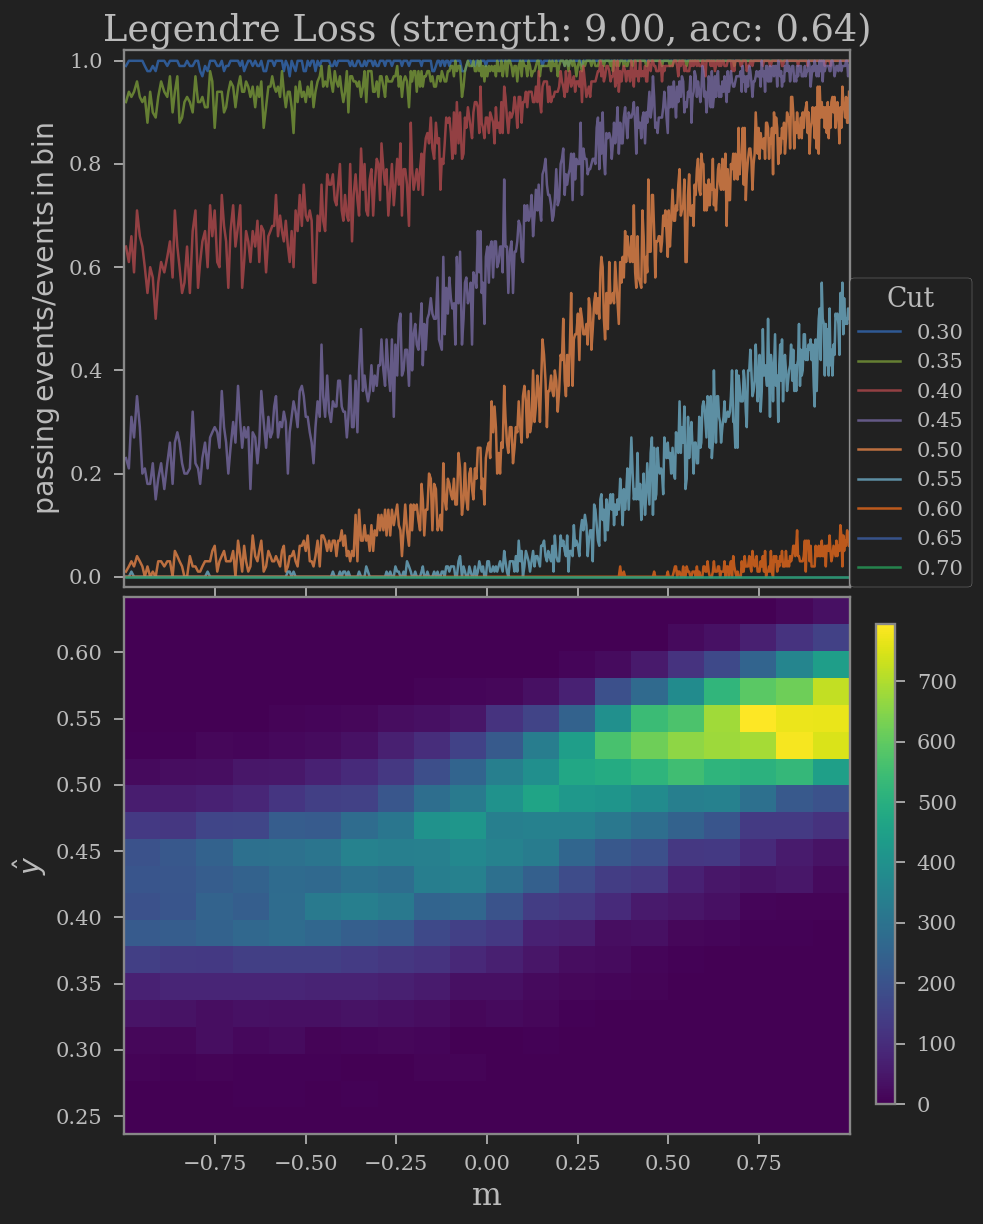

In [274]:
for frac in np.linspace(0,0.99,12):
    print(frac)
    strength = frac/(1-frac)
    metrics_train_legendre = Metrics()
    metrics_val_legendre = Metrics()
    model_legendre = Classifier()
    model_legendre.loss = LegendreLoss(frac=frac)
    model_legendre.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=2000,
                       metrics=[metrics_train_legendre,metrics_val_legendre], 
                       val_data=[x_val_tensor[:,1:],y_val_tensor])

    print(metrics_val_legendre.accs[-1])
    print(metrics_val_legendre.signalE[-1])
    print(metrics_val_legendre.backgroundE[-1])

    scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
    m = m_t.reshape(-1,100).mean(axis=1)



    fig, [ax1, ax2]  = plt.subplots(2,1,figsize=[8,5*2],dpi=120,sharex=True)
    for j,cut in enumerate(np.linspace(0.3,0.7,9)):
        c = f"C{j}" if j!= 6 else f"C11"
        passed = (scores>cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.2f}".format(cut),alpha=0.7,c=c)

        #plt.plot(m,legendre[:,i*10],label="fit",ls='--')
    #plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=17)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_title("Legendre Loss (strength: {:.02f}, acc: {:.02})".format(strength, metrics_val_legendre.accs[-1]),fontsize=22)
    ax1.legend(loc=(1,0),markerscale=5,title="Cut",ncol=1)

    _,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=20, label="all",)#norm=LogNorm())
    cbaxes = fig.add_axes([0.9, 0.09, 0.02, 0.4]) 
    plt.colorbar(h,ax=ax2,cax = cbaxes)
    ax2.set_ylabel(r"$\hat{y}$",fontsize=17)
    ax2.set_xlabel("m",fontsize=19)
    fig.tight_layout(pad=0)
    plt.show()

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


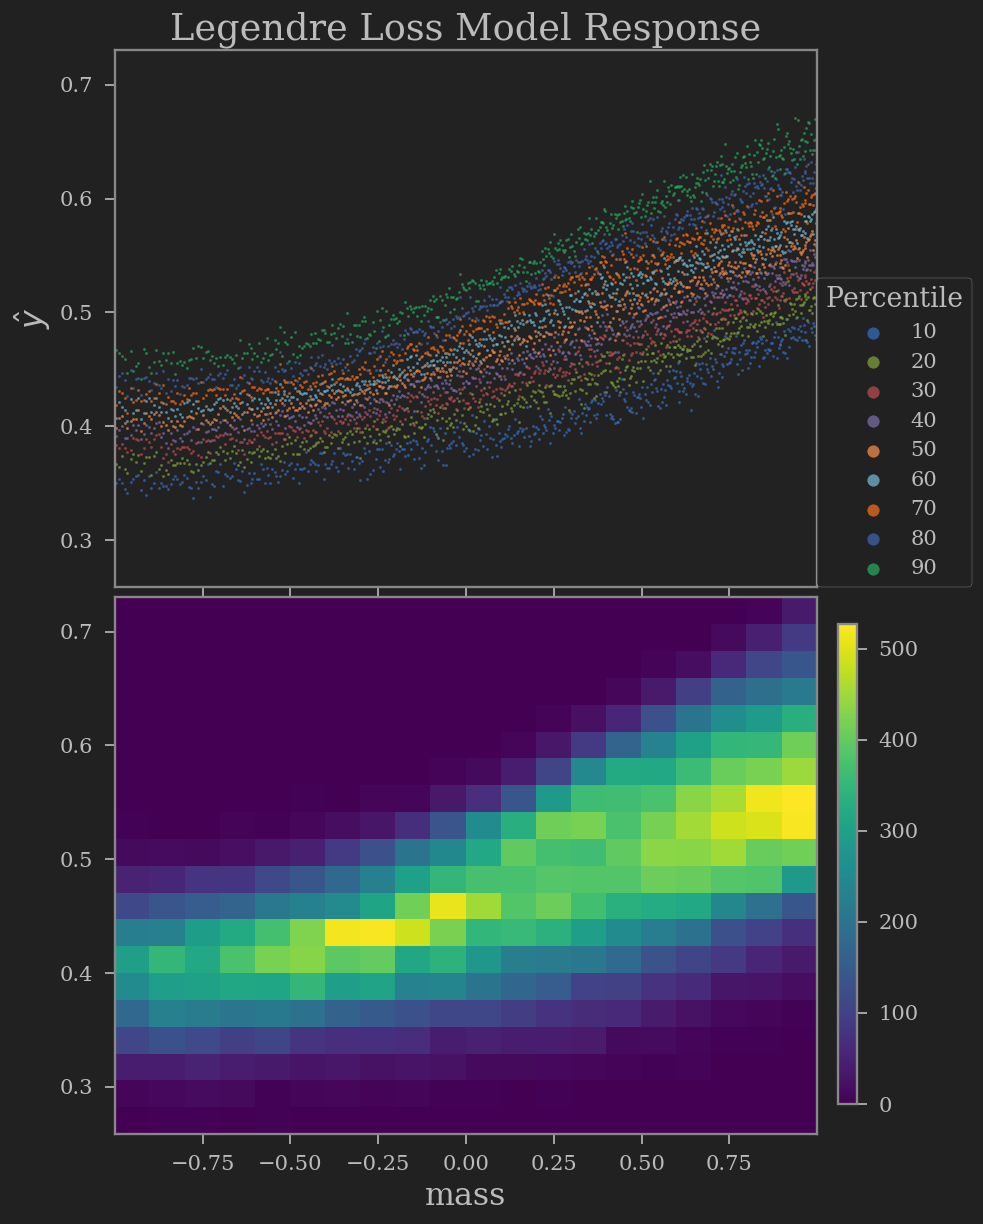

In [253]:
scores = np.array(model_legendre(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
ordered_score = scores.argsort(axis=1)
scores = scores[np.arange(scores.shape[0])[:, None], ordered_score]


fig, [ax1, ax2]  = plt.subplots(2,1,figsize=[8,5*2],dpi=120,sharex=True,sharey=True)
for j,i in enumerate(range(10,scores.shape[1],10)):
    c = f"C{j}" if j!= 6 else f"C11"
    ax1.scatter(m,scores[:,i],label=f"{int(i*100/scores.shape[1])}",alpha=0.7,s=2,c=c)

    #plt.plot(m,legendre[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
ax1.set_ylabel(r"$\hat{y}$",fontsize=19)
ax1.set_title("Legendre Loss Model Response",fontsize=22)
ax1.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=1)

_,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=20, label="all")#norm=LogNorm())
cbaxes = fig.add_axes([0.86, 0.09, 0.02, 0.4]) 
plt.colorbar(h,ax=ax2,cax = cbaxes)
ax2.set_xlabel("mass",fontsize=19)
#plt.ylim([0,0.7])
fig.tight_layout(pad=0)
plt.show()

In [ ]:
metrics_train_jiang = Metrics()
metrics_val_jiang = Metrics()
model_jiang = Classifier()
model_jiang.loss = JiangLoss(eta=1e-3)
model_jiang.fit(x_train_tensor[:,1:],y_train_tensor,n_epochs=1400, delay_loss=1200,
                metrics=[metrics_train_jiang,metrics_val_jiang], 
                val_data=[x_val_tensor[:,1:],y_val_tensor])

Epoch:0000/1400 || Train: loss:0.2488, acc:50% || Test: loss: 0.2486, acc:50%
Epoch:0100/1400 || Train: loss:0.2417, acc:60% || Test: loss: 0.2416, acc:60%
Epoch:0200/1400 || Train: loss:0.2356, acc:61% || Test: loss: 0.2354, acc:61%
Epoch:0300/1400 || Train: loss:0.2307, acc:62% || Test: loss: 0.2304, acc:62%
Epoch:0400/1400 || Train: loss:0.2268, acc:63% || Test: loss: 0.2264, acc:63%
Epoch:0500/1400 || Train: loss:0.2225, acc:64% || Test: loss: 0.2222, acc:64%
Epoch:0600/1400 || Train: loss:0.2168, acc:66% || Test: loss: 0.2166, acc:66%
Epoch:0700/1400 || Train: loss:0.2099, acc:68% || Test: loss: 0.2100, acc:68%
Epoch:0800/1400 || Train: loss:0.2028, acc:70% || Test: loss: 0.2033, acc:70%
Epoch:0900/1400 || Train: loss:0.1961, acc:72% || Test: loss: 0.1970, acc:72%
Epoch:1000/1400 || Train: loss:0.1895, acc:74% || Test: loss: 0.1908, acc:74%
Epoch:1100/1400 || Train: loss:0.1833, acc:76% || Test: loss: 0.1851, acc:75%
Epoch:1200/1400 || Train: loss:0.0891, acc:76% || Test: loss: 0.

In [ ]:
scores = np.array(model_jiang(x_test_tensor[:,1:]).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
ordered_score = scores.argsort(axis=1)
scores = scores[np.arange(scores.shape[0])[:, None], ordered_score]


fig, [ax1, ax2]  = plt.subplots(2,1,figsize=[8,5*2],dpi=120,sharex=True,sharey=True)
for j,i in enumerate(range(10,scores.shape[1],10)):
    c = f"C{j}" if j!= 6 else f"C11"
    ax1.scatter(m,scores[:,i],label=f"{int(i*100/scores.shape[1])}",alpha=0.7,s=2,c=c)

    #plt.plot(m,jiang[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
ax1.set_ylabel(r"$\hat{y}$",fontsize=19)
ax1.set_title("Jiang Loss Model Response",fontsize=22)
ax1.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=1)

_,_,_,h = ax2.hist2d(m_t,scores.flatten(),bins=20, label="all")#norm=LogNorm())
cbaxes = fig.add_axes([0.86, 0.09, 0.02, 0.4]) 
plt.colorbar(h,ax=ax2,cax = cbaxes)
ax2.set_xlabel("mass",fontsize=19)
#plt.ylim([0,0.7])
fig.tight_layout(pad=0)
plt.show()